# Sentinel-2の観測画像のpythonのjupyter noteboook(lab)をプラットフォームに取得する方法


目的：pythonのjupyter labにて，希望する地域のSentinel-2の観測画像を日付を希望してダウンロードする．
その関心地域を含むSentinel-2の１シーン画像全体（１００km四方）のGeotiffデータや，関心域のみを抽出したGeotiff画像を作成する．

ここで利用する関心地域の情報は，米国キーン州立大学が提供している地理情報のWebアプリケーションを参考にしました．

SentinelのAPIを含め，必要なモジュールを総合開発環境(python）にインストールする．

In [1]:
!pip install sentinelsat
!pip install rasterio
!pip install folium
!apt install gdal-bin python-gdal python3-gdal 
!apt install python3-rtree 
!pip install git+git://github.com/geopandas/geopandas.git
!pip install descartes 


E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
  Cloning git://github.com/geopandas/geopandas.git to /tmp/pip-req-build-sn3nzu33
  Running command git clone -q git://github.com/geopandas/geopandas.git /tmp/pip-req-build-sn3nzu33
     |████████████████████████████████| 10.1MB 2.1MB/s eta 0:00:01
  Created wheel for geopandas: filename=geopandas-0.6.1+37.g1d212b2-py2.py3-none-any.whl size=922058 sha256=1cc908db42a57357e7e7a6240bd9a3d9ba682c81a98d89c47252430a9dcb9371
  Stored in directory: /tmp/pip-ephem-wheel-cache-3gxsd0sn/wheels/91/24/71/376c9c67192694168352afcccc2d264248f7e2cc6192997186
Successfully built geopandas
  Found existing installation: pyproj 1.9.6
    Uninstalling pyproj-1.9

geopandasを使うための関連モジュールもインストールする．

In [2]:
!pip install shapely
!pip install fiona
!pip install six
!pip install pyproj
!pip install descartes
!pip install geopandas

In [3]:
import folium
import os

from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt 
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from shapely.geometry import MultiPolygon, Polygon
import rasterio as rio
from rasterio.plot import show
import rasterio.mask
import fiona

米国キーン州立大学が提供するGISのWebアプリケーションを用いて，関心域の緯度・経度情報を取得する．

In [4]:
#関心領域のポリゴン情報の取得．
from IPython.display import HTML
HTML(r'<iframe width="960" height="480" src="https://www.keene.edu/campus/maps/tool/" frameborder="0"></iframe>')

/opt/conda/lib/python3.7/site-packages/IPython/core/display.py:694: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [5]:
#上記にて取得した地理情報をコピペ．
AREA =  [
      [
        -220.4038526,
        35.7080337
      ],
      [
        -220.4059125,
        35.7091488
      ],
      [
        -220.4045393,
        35.5059426
      ],
      [
        -220.08938,
        35.5076195
      ],
      [
        -220.0900666,
        35.7030155
      ],
      [
        -220.4038526,
        35.7080337
      ]
    ]

In [6]:
for i in range(len(AREA)):
    AREA[i][0] = AREA[i][0] +360

関心域の地理情報ポリゴンの作成

In [7]:
from geojson import Polygon

# no hole within polygon
m=Polygon([AREA]) 

今後使用する任意のファイル名をセットする．

In [9]:
object_name = 'Tokyo_bay'

In [10]:
import json
with open(str(object_name) +'.geojson', 'w') as f:
    json.dump(m, f)

In [11]:
footprint_geojson = geojson_to_wkt(read_geojson(str(object_name) +'.geojson'))

コペルニクスハブのアカウントを入力する．

コペルニクスのアカウントの取得方法は，
例えば，以下のサイトを参考にするなどを紹介してください．

[無料で最新の衛星画像を入手する方法．](https://qiita.com/nigo1973/items/9bb6a11caac8e3e1e850)

In [13]:
user = 'nigo1973' 
password = 'taiyo1231' 

api = SentinelAPI(user, password, 'https://scihub.copernicus.eu/dhus')

foliumの地図閲覧機能を用いて関心域を確認する．

Sentinel APIを用いて，Sentinel-2の観測画像の選択情報をインプットする．

In [14]:
m = folium.Map([(AREA[0][1]+AREA[len(AREA)-1][1])/2,(AREA[0][0]+AREA[len(AREA)-1][0])/2], zoom_start=10)

folium.GeoJson(str(object_name) +'.geojson').add_to(m)
m

In [12]:
user = '*******' 
password = '********' 

api = SentinelAPI(user, password, 'https://scihub.copernicus.eu/dhus')

In [15]:
products = api.query(footprint_geojson,
                     date = ('20191201', '20200110'), #取得希望期間の入力
                     platformname = 'Sentinel-2',
                     processinglevel = 'Level-2A',
                     cloudcoverpercentage = (0,100)) #被雲率（0％〜100％）

下記のエラーが表示される場合は，関心域がSentinel-2の提供画像エリアよりも大きいか，適切な画像がない場合に多くみれます．
関心域を縮小するなどの対応にて，エラーが発生しない関心域のエリア設定を試みてください．
SentinelAPIError: HTTP status 200 OK: Invalid query string. Check the parameters and format.


取得希望期間，被雲率にあう観測履歴数を確認する．

In [16]:
len(products)

16

要求期間で一番雲が少ない画像を選択する．

In [17]:
products_gdf = api.to_geodataframe(products)
products_gdf_sorted = products_gdf.sort_values(['cloudcoverpercentage'], ascending=[True])
products_gdf_sorted

/opt/conda/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


,title,link,link_alternative,link_icon,summary,beginposition,endposition,ingestiondate,orbitnumber,relativeorbitnumber,...,processingbaseline,processinglevel,producttype,platformname,size,filename,level1cpdiidentifier,identifier,uuid,geometry
58cd18db-9f34-4f89-b6a4-e5280b69286c,S2B_MSIL2A_20191229T013049_N0213_R074_T54SVE_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2019-12-29T01:30:49.024Z, Instrument: MS...",2019-12-29 01:30:49.024,2019-12-29 01:30:49.024,2019-12-30 03:21:37.871,14686,74,...,02.13,Level-2A,S2MSI2A,Sentinel-2,962.74 MB,S2B_MSIL2A_20191229T013049_N0213_R074_T54SVE_2...,S2B_OPER_MSI_L1C_TL_EPAE_20191229T030611_A0146...,S2B_MSIL2A_20191229T013049_N0213_R074_T54SVE_2...,58cd18db-9f34-4f89-b6a4-e5280b69286c,"MULTIPOLYGON (((139.90171 35.14991, 140.87144 ..."
771d9847-d82a-4ce7-8113-62c6b6acd363,S2A_MSIL2A_20191204T013031_N0213_R074_T54SVE_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2019-12-04T01:30:31.024Z, Instrument: MS...",2019-12-04 01:30:31.024,2019-12-04 01:30:31.024,2019-12-04 10:30:39.473,23237,74,...,02.13,Level-2A,S2MSI2A,Sentinel-2,948.93 MB,S2A_MSIL2A_20191204T013031_N0213_R074_T54SVE_2...,S2A_OPER_MSI_L1C_TL_EPAE_20191204T032444_A0232...,S2A_MSIL2A_20191204T013031_N0213_R074_T54SVE_2...,771d9847-d82a-4ce7-8113-62c6b6acd363,"MULTIPOLYGON (((139.90171 35.14991, 140.86356 ..."
a73fcc80-4850-4ab4-a199-301441307a0e,S2A_MSIL2A_20191214T013041_N0213_R074_T54SUE_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2019-12-14T01:30:41.024Z, Instrument: MS...",2019-12-14 01:30:41.024,2019-12-14 01:30:41.024,2019-12-14 06:43:50.962,23380,74,...,02.13,Level-2A,S2MSI2A,Sentinel-2,1.08 GB,S2A_MSIL2A_20191214T013041_N0213_R074_T54SUE_2...,S2A_OPER_MSI_L1C_TL_EPAE_20191214T032430_A0233...,S2A_MSIL2A_20191214T013041_N0213_R074_T54SUE_2...,a73fcc80-4850-4ab4-a199-301441307a0e,"MULTIPOLYGON (((138.80483 35.13500, 140.00972 ..."
5d6e2451-8b37-4e2c-8796-c9532ece3f78,S2A_MSIL2A_20191204T013031_N0213_R074_T54SUE_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2019-12-04T01:30:31.024Z, Instrument: MS...",2019-12-04 01:30:31.024,2019-12-04 01:30:31.024,2019-12-04 10:07:56.689,23237,74,...,02.13,Level-2A,S2MSI2A,Sentinel-2,1.09 GB,S2A_MSIL2A_20191204T013031_N0213_R074_T54SUE_2...,S2A_OPER_MSI_L1C_TL_EPAE_20191204T032444_A0232...,S2A_MSIL2A_20191204T013031_N0213_R074_T54SUE_2...,5d6e2451-8b37-4e2c-8796-c9532ece3f78,"MULTIPOLYGON (((138.80483 35.13500, 140.00972 ..."
da95c8f3-9305-47be-9fe4-f6517b646939,S2A_MSIL2A_20200103T013041_N0213_R074_T54SUE_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2020-01-03T01:30:41.024Z, Instrument: MS...",2020-01-03 01:30:41.024,2020-01-03 01:30:41.024,2020-01-03 06:46:44.084,23666,74,...,02.13,Level-2A,S2MSI2A,Sentinel-2,1.08 GB,S2A_MSIL2A_20200103T013041_N0213_R074_T54SUE_2...,S2A_OPER_MSI_L1C_TL_EPAE_20200103T032332_A0236...,S2A_MSIL2A_20200103T013041_N0213_R074_T54SUE_2...,da95c8f3-9305-47be-9fe4-f6517b646939,"MULTIPOLYGON (((138.80483 35.13500, 140.00972 ..."
1a592cfc-01e7-4213-8adf-3499cec4f814,S2A_MSIL2A_20191214T013041_N0213_R074_T54SVE_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2019-12-14T01:30:41.024Z, Instrument: MS...",2019-12-14 01:30:41.024,2019-12-14 01:30:41.024,2019-12-14 06:46:45.487,23380,74,...,02.13,Level-2A,S2MSI2A,Sentinel-2,968.84 MB,S2A_MSIL2A_20191214T013041_N0213_R074_T54SVE_2...,S2A_OPER_M

In [18]:
products_gdf_sorted.head()

,title,link,link_alternative,link_icon,summary,beginposition,endposition,ingestiondate,orbitnumber,relativeorbitnumber,...,processingbaseline,processinglevel,producttype,platformname,size,filename,level1cpdiidentifier,identifier,uuid,geometry
58cd18db-9f34-4f89-b6a4-e5280b69286c,S2B_MSIL2A_20191229T013049_N0213_R074_T54SVE_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2019-12-29T01:30:49.024Z, Instrument: MS...",2019-12-29 01:30:49.024,2019-12-29 01:30:49.024,2019-12-30 03:21:37.871,14686,74,...,02.13,Level-2A,S2MSI2A,Sentinel-2,962.74 MB,S2B_MSIL2A_20191229T013049_N0213_R074_T54SVE_2...,S2B_OPER_MSI_L1C_TL_EPAE_20191229T030611_A0146...,S2B_MSIL2A_20191229T013049_N0213_R074_T54SVE_2...,58cd18db-9f34-4f89-b6a4-e5280b69286c,"MULTIPOLYGON (((139.90171 35.14991, 140.87144 ..."
771d9847-d82a-4ce7-8113-62c6b6acd363,S2A_MSIL2A_20191204T013031_N0213_R074_T54SVE_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2019-12-04T01:30:31.024Z, Instrument: MS...",2019-12-04 01:30:31.024,2019-12-04 01:30:31.024,2019-12-04 10:30:39.473,23237,74,...,02.13,Level-2A,S2MSI2A,Sentinel-2,948.93 MB,S2A_MSIL2A_20191204T013031_N0213_R074_T54SVE_2...,S2A_OPER_MSI_L1C_TL_EPAE_20191204T032444_A0232...,S2A_MSIL2A_20191204T013031_N0213_R074_T54SVE_2...,771d9847-d82a-4ce7-8113-62c6b6acd363,"MULTIPOLYGON (((139.90171 35.14991, 140.86356 ..."
a73fcc80-4850-4ab4-a199-301441307a0e,S2A_MSIL2A_20191214T013041_N0213_R074_T54SUE_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2019-12-14T01:30:41.024Z, Instrument: MS...",2019-12-14 01:30:41.024,2019-12-14 01:30:41.024,2019-12-14 06:43:50.962,23380,74,...,02.13,Level-2A,S2MSI2A,Sentinel-2,1.08 GB,S2A_MSIL2A_20191214T013041_N0213_R074_T54SUE_2...,S2A_OPER_MSI_L1C_TL_EPAE_20191214T032430_A0233...,S2A_MSIL2A_20191214T013041_N0213_R074_T54SUE_2...,a73fcc80-4850-4ab4-a199-301441307a0e,"MULTIPOLYGON (((138.80483 35.13500, 140.00972 ..."
5d6e2451-8b37-4e2c-8796-c9532ece3f78,S2A_MSIL2A_20191204T013031_N0213_R074_T54SUE_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2019-12-04T01:30:31.024Z, Instrument: MS...",2019-12-04 01:30:31.024,2019-12-04 01:30:31.024,2019-12-04 10:07:56.689,23237,74,...,02.13,Level-2A,S2MSI2A,Sentinel-2,1.09 GB,S2A_MSIL2A_20191204T013031_N0213_R074_T54SUE_2...,S2A_OPER_MSI_L1C_TL_EPAE_20191204T032444_A0232...,S2A_MSIL2A_20191204T013031_N0213_R074_T54SUE_2...,5d6e2451-8b37-4e2c-8796-c9532ece3f78,"MULTIPOLYGON (((138.80483 35.13500, 140.00972 ..."
da95c8f3-9305-47be-9fe4-f6517b646939,S2A_MSIL2A_20200103T013041_N0213_R074_T54SUE_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2020-01-03T01:30:41.024Z, Instrument: MS...",2020-01-03 01:30:41.024,2020-01-03 01:30:41.024,2020-01-03 06:46:44.084,23666,74,...,02.13,Level-2A,S2MSI2A,Sentinel-2,1.08 GB,S2A_MSIL2A_20200103T013041_N0213_R074_T54SUE_2...,S2A_OPER_MSI_L1C_TL_EPAE_20200103T032332_A0236...,S2A_MSIL2A_20200103T013041_N0213_R074_T54SUE_2...,da95c8f3-9305-47be-9fe4-f6517b646939,"MULTIPOLYGON (((138.80483 35.13500, 140.00972 ..."


In [19]:
uuid = products_gdf_sorted.iloc[0]["uuid"]

In [20]:
product_title = products_gdf_sorted.iloc[0]["title"]

Sentinel-2の観測画像のダウンロードする．

In [21]:
api.download(uuid)

Downloading: 100%|██████████| 1.01G/1.01G [20:19<00:00, 902kB/s] 
MD5 checksumming: 100%|██████████| 1.01G/1.01G [00:03<00:00, 327MB/s]


{'id': '58cd18db-9f34-4f89-b6a4-e5280b69286c',
 'title': 'S2B_MSIL2A_20191229T013049_N0213_R074_T54SVE_20191229T034601',
 'size': 1009560109,
 'md5': '85E2DE03C1ABD9E7F534FE9457EF52E4',
 'date': datetime.datetime(2019, 12, 29, 1, 30, 49, 24000),
 'footprint': 'POLYGON((141.10814949540676 35.89175828658656,141.0778434231089 35.797915286645214,141.0305619073971 35.651037325192654,140.98334202216876 35.504134099692564,140.93625383347035 35.35718985181452,140.88933676508515 35.21021016827614,140.8714427490419 35.15387850912383,139.90170709137837 35.149912058963785,139.88807490781303 36.139736604513345,141.10848960794797 36.14484927635336,141.10814949540676 35.89175828658656))',
 'url': "https://scihub.copernicus.eu/dhus/odata/v1/Products('58cd18db-9f34-4f89-b6a4-e5280b69286c')/$value",
 'Online': True,
 'Creation Date': datetime.datetime(2019, 12, 30, 3, 22, 5, 997000),
 'Ingestion Date': datetime.datetime(2019, 12, 30, 3, 21, 37, 871000),
 'path': './S2B_MSIL2A_20191229T013049_N0213_R074_

## Rasterioを用いて取得したSentinel２の観測画像の確認，および関心域を抽出する．


### True Imageを作成する． 
Sentinel-2のBand4,3,2によるTrue Imageを作成する．

In [22]:
file_name = str(product_title) +'.zip'

In [23]:
import zipfile
with zipfile.ZipFile(file_name) as zf:
 zf.extractall()

In [24]:
import os

path = str(product_title) + '.SAFE/GRANULE'
files = os.listdir(path)

pathA = str(product_title) + '.SAFE/GRANULE/' + str(files[0])
files2 = os.listdir(pathA)

pathB = str(product_title) + '.SAFE/GRANULE/' + str(files[0]) +'/' + str(files2[1]) +'/R10m'
files3 = os.listdir(pathB)

Sentinel-2のNatural Imageを作成するために，バンド２，３，４（R,G,B)を選択する．

In [25]:
path_b2 = str(product_title) + '.SAFE/GRANULE/' + str(files[0]) +'/' + str(files2[1]) +'/R10m/' +str(files3[0][0:23] +'B02_10m.jp2')
path_b3 = str(product_title) + '.SAFE/GRANULE/' + str(files[0]) +'/' + str(files2[1]) +'/R10m/' +str(files3[0][0:23] +'B03_10m.jp2')
path_b4 = str(product_title) + '.SAFE/GRANULE/' + str(files[0]) +'/' + str(files2[1]) +'/R10m/' +str(files3[0][0:23] +'B04_10m.jp2')

In [26]:
# Open Bands 4, 3 and 2 with Rasterio

b4 = rio.open(path_b4)
b3 = rio.open(path_b3)
b2 = rio.open(path_b2)

バンド４を代表として画像サイズの情報や，画像そのものを確認する．

In [27]:
b4.count, b4.width, b4.height

(1, 10980, 10980)

In [28]:
b4.crs

CRS.from_epsg(32654)

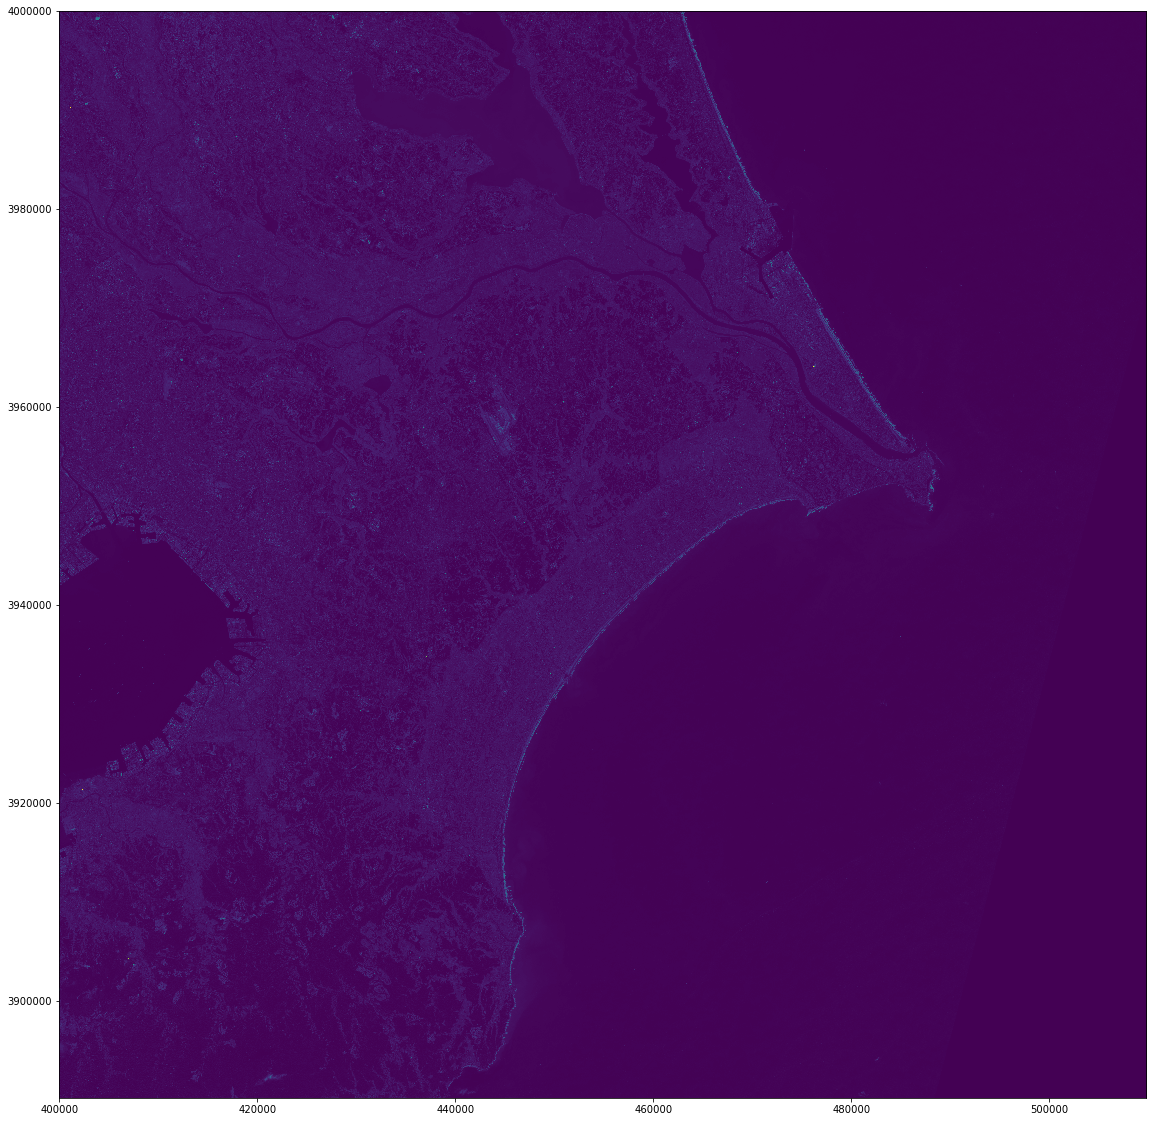

In [29]:
fig, ax = plt.subplots(1, figsize=(20, 20))
show(b4, ax=ax)
plt.show()

バンド，４，３，２をR,G,BとしてNatunal ImageのGeotiff画像を作成する．
ここで作成したファイルはQGISなどのローカルのGISソフトで解析できる．
（作成した画像をローカルにダウンロードして用いる場合）

In [30]:
with rio.open(str(object_name) +'.tiff','w',driver='Gtiff', width=b4.width, height=b4.height, 
              count=3,crs=b4.crs,transform=b4.transform, dtype=b4.dtypes[0]) as rgb:
    rgb.write(b2.read(1),3) 
    rgb.write(b3.read(1),2) 
    rgb.write(b4.read(1),1) 
    rgb.close()

### 関心域の衛星画像を抽出する．



In [32]:
nReserve_geo = gpd.read_file(str(object_name) +'.geojson')

Sentinel-2の画像のEPSG情報が地域によって異なるため，ダウンロードしたSentinel-2の画像から自動識別します．

[EPSGとは．](http://club.informatix.co.jp/?p=1225)


In [33]:
epsg = b4.crs

ダウンロードしたSentinel-2の１シーンの画像（１００ｋｍ四方）から，関心域のみを抽出する．
ここで抽出した画像はGeotiffファイルなので，先と同じくローカルにダウロードすると，QGISなどのGISソフトでの解析が可能．

In [34]:
#src = rio.open(r"RGB.tiff")
nReserve_proj = nReserve_geo.to_crs({'init': epsg})

with rio.open(str(object_name) +'.tiff') as src:
    out_image, out_transform = rio.mask.mask(src, nReserve_proj.geometry,crop=True)
    out_meta = src.meta.copy()
    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
    
with rasterio.open('Masked_' +str(object_name) +'.tif', "w", **out_meta) as dest:
    dest.write(out_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


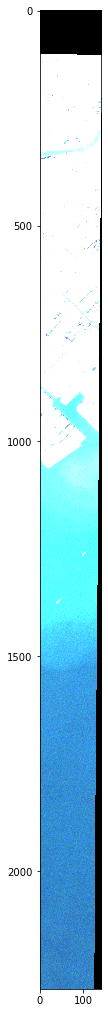

<function matplotlib.pyplot.show(*args, **kw)>

In [35]:
msk = rio.open(r'Masked_' +str(object_name) +'.tif')
fig, ax = plt.subplots(1, figsize=(18, 18))
show(msk.read([1,2,3]))
plt.show

### ローカルにて閲覧するためのjpeg画像を作成する．

In [36]:
from osgeo import gdal

scale = '-scale 0 250 0 30'
options_list = [
    '-ot Byte',
    '-of JPEG',
    scale
] 
options_string = " ".join(options_list)

gdal.Translate('Masked_' +str(object_name) +'.jpg',
               'Masked_' +str(object_name) +'.tif',
               options=options_string)

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7fd9dcb08fc0> >

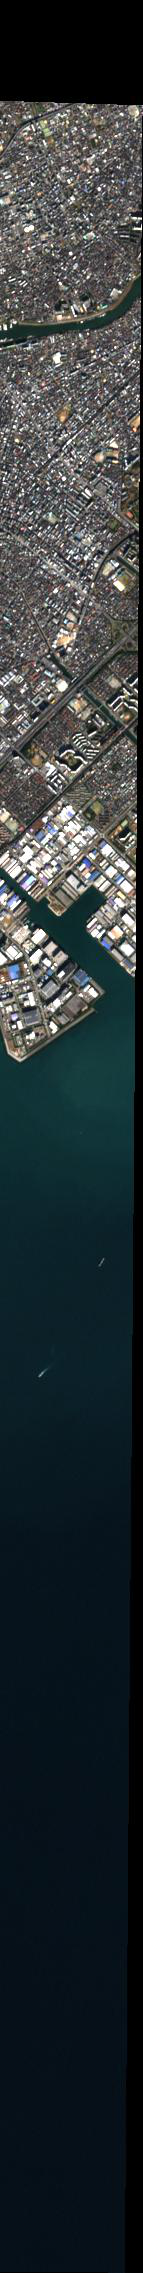

In [37]:
from PIL import Image
im = Image.open('Masked_' +str(object_name) +'.jpg')
im

# まとめ
pythonでのSentinel-2の画像データのダウンロード，およびTrue　ImageをGeotiffを作成した．
また，Sentinel-2の１シーンの画像サイズは大きいため，関心域のみの画像の抽出，およびローカルにてGoole Earthにて閲覧するためのkmzファイルを作成したい．
関心域は地理院タイル座標で準備しており，Tellusの他の衛星画像との親和性を高くしています．